# Happy Customers Project – Data Analysis & Predictive Modeling

This notebook provides a complete workflow for analyzing customer happiness survey data and building predictive models. The process begins with loading and exploring the dataset, validating its quality, and visualizing feature distributions. It then proceeds to model development using Logistic Regression and Random Forest, followed by feature importance analysis and permutation importance to identify key drivers of customer happiness. Finally, the notebook applies feature selection and model evaluation techniques to optimize performance and extract actionable insights.

In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier

from itertools import combinations


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
print("Libraries ready.")

Libraries ready.


## Loading and Inspecting the Dataset

In [2]:
CSV_PATH = "C:/Users/hasan/OneDrive/Desktop/Apziva/1. Happy Customers Project/ACME-HappinessSurvey2020.csv"  
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
display(df.head(10))

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nDescribe:\n", df.describe())

Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5
5  1   5   5   3   5   5   5
6  0   3   1   2   2   1   3
7  1   5   4   4   4   4   5
8  0   4   1   4   4   4   4
9  0   4   4   4   2   5   5

Shape: (126, 7)
Columns: ['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6']

Dtypes:
 Y     int64
X1    int64
X2    int64
X3    int64
X4    int64
X5    int64
X6    int64
dtype: object

Describe:
                 Y          X1          X2          X3          X4          X5          X6
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794    4.253968
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641    0.809311
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000    4.000000
50%      1.000000    5.000000    3.000000    3.000000    4.000000    4.000000    4.000000
75%      1.000000    5.000000    3.000000    4.000000    4.000000    4.000000    5.000000
max      1.000000    5.000000    5.000000    5.000000    5.000000    5.000000    5.000000


## Data Quality and Feature Validation

This section of the code performs initial data validation and checks to ensure the dataset is ready for modeling. It first calculates and displays the number of missing values per column, helping to identify data quality issues. Next, it verifies the existence of the target column Y, raising an error if it is missing. The distribution of target values is then displayed to understand class balance. Finally, the script checks whether all six expected features (X1 through X6) are present in the dataset. If any are missing, it issues a warning and proceeds with only the available features. This step ensures that both target and feature columns are properly set up before training models.

In [3]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing)

if "Y" not in df.columns:
    raise ValueError("Target column 'Y' is missing.")

print("\nTarget distribution (Y):\n", df["Y"].value_counts(dropna=False))

expected_features = [f"X{i}" for i in range(1, 7)]
available_features = [c for c in expected_features if c in df.columns]
if len(available_features) != 6:
    print("WARNING: Some of X1..X6 missing; using:", available_features)
else:
    print("Using features:", available_features)

Missing values per column:
 Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

Target distribution (Y):
 Y
1    69
0    57
Name: count, dtype: int64
Using features: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']


## Exploratory Data Analysis: Feature Distributions and Correlations

This section provides an initial exploration of the dataset by visualizing the distributions of the input features and the target variable. Histograms are plotted for each feature to understand their spread and frequency. The target variable (`Y`) is displayed as a bar chart to show the balance between happy (1) and unhappy (0) customers. Finally, a correlation heatmap is generated to examine the relationships among features as well as their correlation with the target, which helps identify potential predictive patterns.

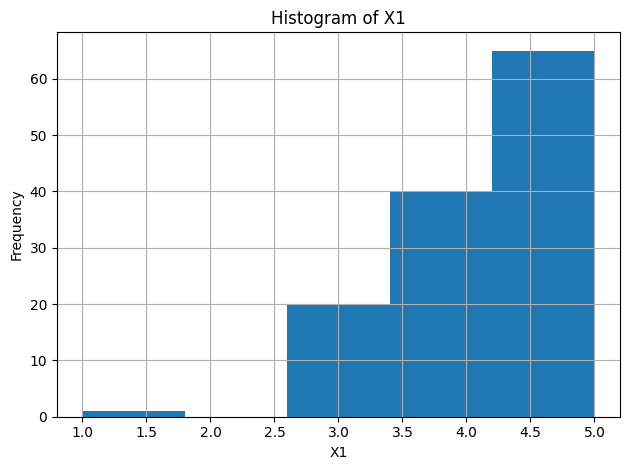

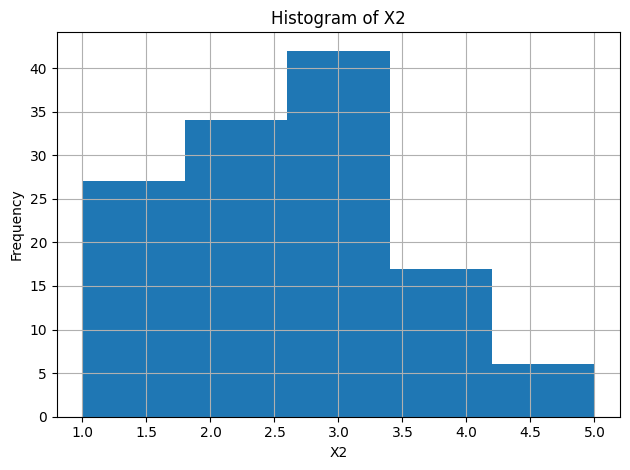

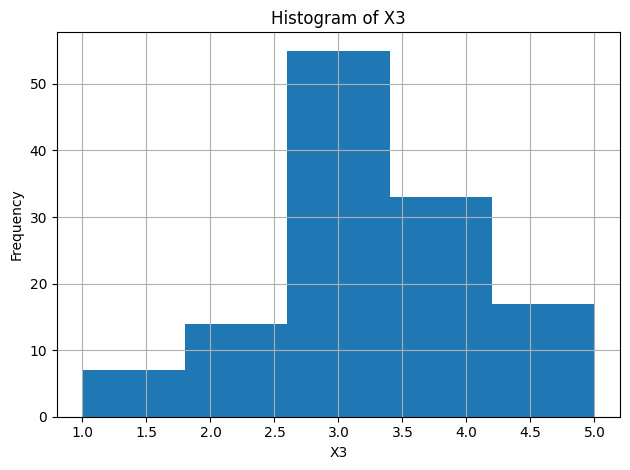

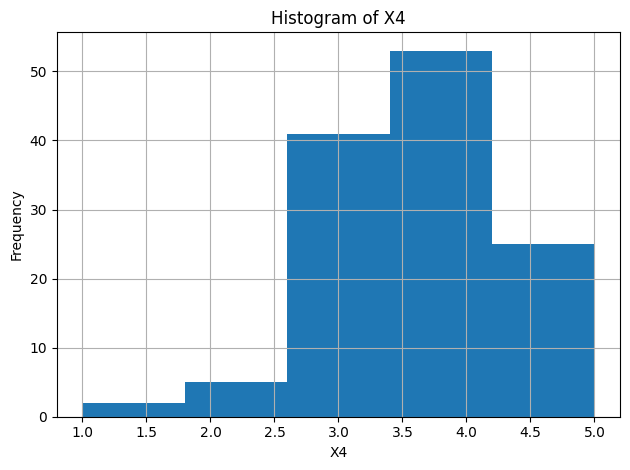

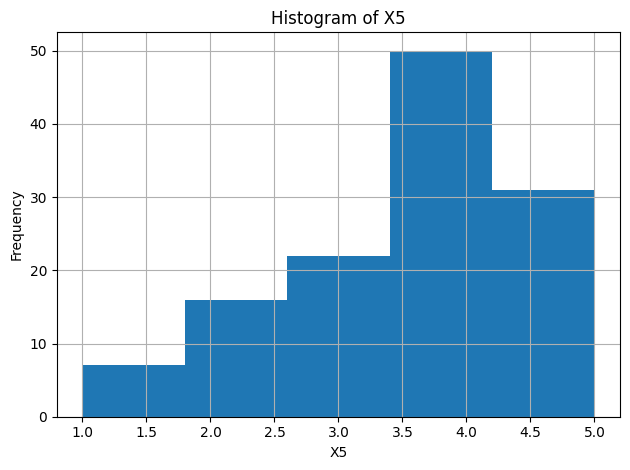

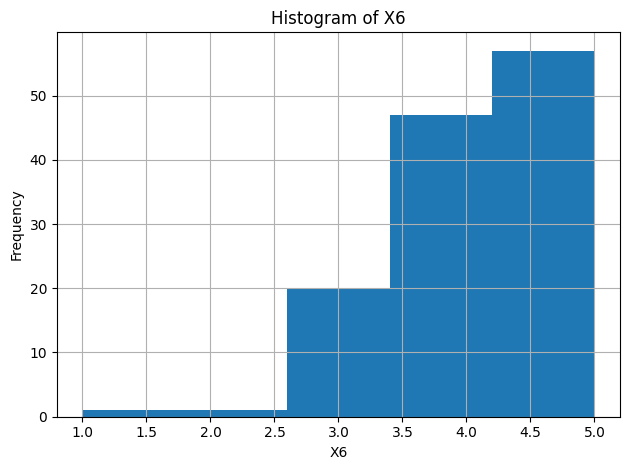

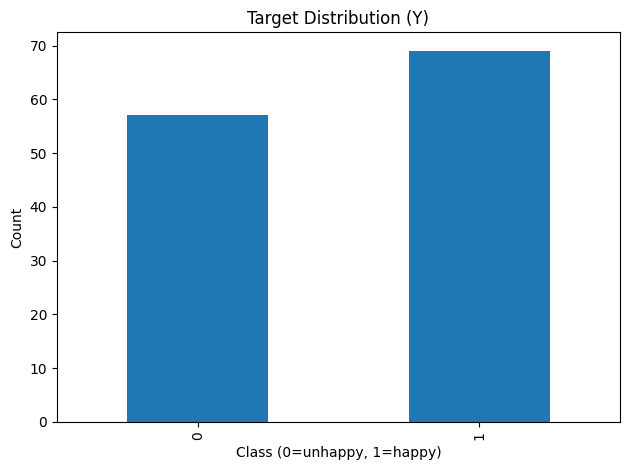

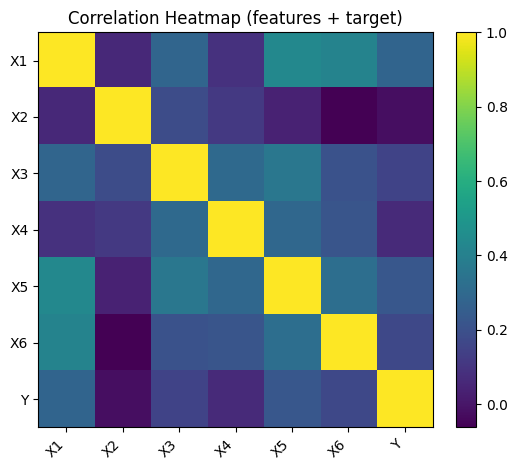

In [4]:
# Histograms
for col in available_features:
    plt.figure()
    df[col].hist(bins=5)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()

# Target bar
plt.figure()
df["Y"].value_counts().sort_index().plot(kind="bar")
plt.title("Target Distribution (Y)")
plt.xlabel("Class (0=unhappy, 1=happy)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Correlation heatmap (features + target)
plt.figure()
corr = df[available_features + ["Y"]].corr(numeric_only=True)
im = plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap (features + target)")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[0]), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

## Baseline Model Training and Evaluation

This section of the code establishes baseline models for the project by training and evaluating two commonly used machine learning algorithms: Logistic Regression and Random Forest. The dataset is split into training and testing sets, after which both models are trained on the training set. Their performance is then assessed on the test set using multiple metrics, including accuracy, precision, recall, F1-score, and ROC-AUC.

To provide further insights, confusion matrices are generated for each model, allowing for a visual comparison of predicted versus actual outcomes. The results of both models are stored in a dataframe (metrics_df) and sorted by accuracy for easier comparison, offering a structured baseline that will serve as a benchmark for evaluating more advanced models later in the project.

Train size: (94, 6)   Test size: (32, 6)

=== LogisticRegression ===
Accuracy: 0.7188 | Precision: 0.6957 | Recall: 0.8889 | F1: 0.7805 | ROC-AUC: 0.7817


<Figure size 640x480 with 0 Axes>

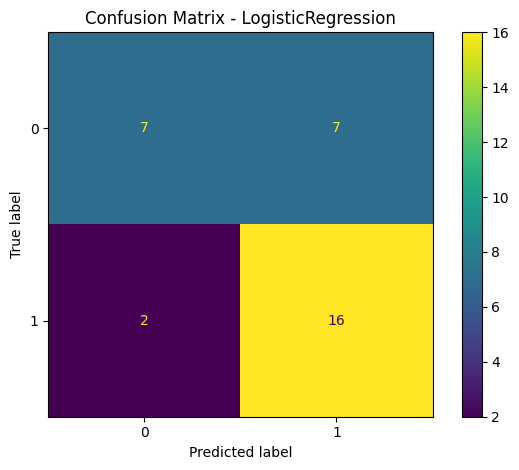


=== RandomForest ===
Accuracy: 0.6562 | Precision: 0.7059 | Recall: 0.6667 | F1: 0.6857 | ROC-AUC: 0.7262


<Figure size 640x480 with 0 Axes>

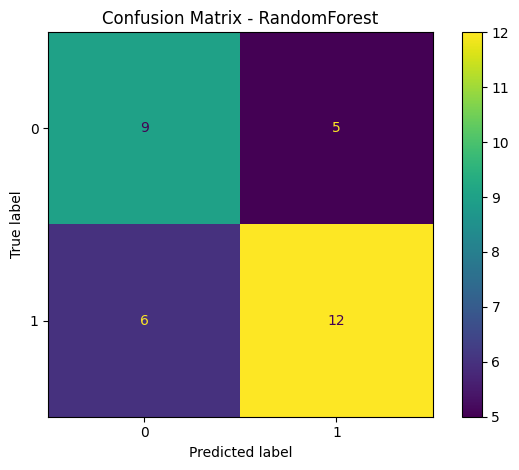

model  accuracy  precision    recall        f1   roc_auc
0  LogisticRegression   0.71875   0.695652  0.888889  0.780488  0.781746
1        RandomForest   0.65625   0.705882  0.666667  0.685714  0.726190

In [5]:
X = df[available_features].copy()
y = df["Y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "  Test size:", X_test.shape)

# --- Cell 6: Baseline Models (LR & RF) ---
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight=None
    )
}

metrics_rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan")

    metrics_rows.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    })

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}", end="")
    if not math.isnan(roc):
        print(f" | ROC-AUC: {roc:.4f}")
    else:
        print()

    # Confusion matrix
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout(); plt.show()

metrics_df = pd.DataFrame(metrics_rows).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
display(metrics_df)

## Feature Importance Analysis: Logistic Regression and Random Forest

This section compares how different models evaluate feature importance. First, a Logistic Regression model is trained, and its standardized coefficients are extracted to show the relative weight of each feature. The absolute values of the coefficients are plotted to visualize their influence on the prediction. Next, a Random Forest model is trained, and its feature importances are computed based on how much each feature contributes to reducing prediction error. The results are sorted and visualized in bar charts, allowing direct comparison of the two models’ perspectives on which features matter most.


LogReg standardized coefficients:
   feature   lr_coef
0      X1  0.266978
4      X5  0.247972
1      X2 -0.162577
2      X3  0.077244
5      X6 -0.053889
3      X4  0.012056


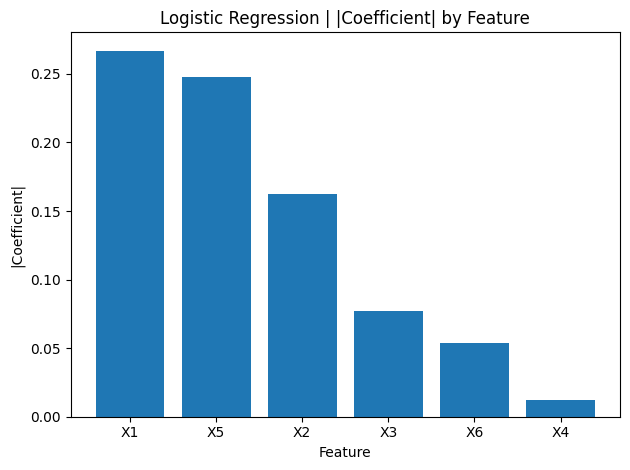


Random Forest feature importances:
   feature  rf_importance
2      X3       0.201967
1      X2       0.188306
4      X5       0.177055
3      X4       0.161492
0      X1       0.153482
5      X6       0.117698


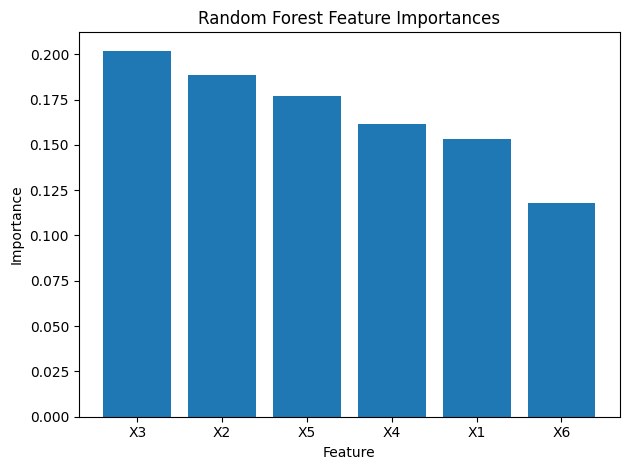

In [6]:
# (a) Logistic Regression coefficients in standardized space
lr_pipe = models["LogisticRegression"]
lr_pipe.fit(X_train, y_train)
lr_coef = lr_pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": available_features, "lr_coef": lr_coef}) \
          .sort_values("lr_coef", key=lambda s: s.abs(), ascending=False)
print("\nLogReg standardized coefficients:\n", coef_df)
plt.figure(); plt.bar(coef_df["feature"], coef_df["lr_coef"].abs())
plt.title("Logistic Regression | |Coefficient| by Feature")
plt.xlabel("Feature"); plt.ylabel("|Coefficient|")
plt.tight_layout(); plt.show()

# (b) Random Forest feature importances
rf_clf = models["RandomForest"]
rf_clf.fit(X_train, y_train)
rf_imp_df = pd.DataFrame({"feature": available_features,
                          "rf_importance": rf_clf.feature_importances_}) \
            .sort_values("rf_importance", ascending=False)
print("\nRandom Forest feature importances:\n", rf_imp_df)
plt.figure(); plt.bar(rf_imp_df["feature"], rf_imp_df["rf_importance"])
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature"); plt.ylabel("Importance")
plt.tight_layout(); plt.show()

## Permutation Importance Analysis

This section evaluates the relative importance of each feature in the best-performing model using **permutation importance**. After identifying the top model from the performance metrics (`metrics_df`), the code retrains it and applies permutation importance on the test set. The results show how much each feature contributes to prediction accuracy by measuring the change in performance when the feature values are shuffled. The importance scores are stored in a dataframe for inspection and visualized in a bar chart for clearer interpretation.


Permutation importance on best model: LogisticRegression


feature  perm_importance_mean  perm_importance_std
0      X1              0.104688             0.046640
4      X5              0.051562             0.059519
1      X2              0.046875             0.033512
2      X3              0.023438             0.013532
5      X6              0.014063             0.020905
3      X4              0.000000             0.000000

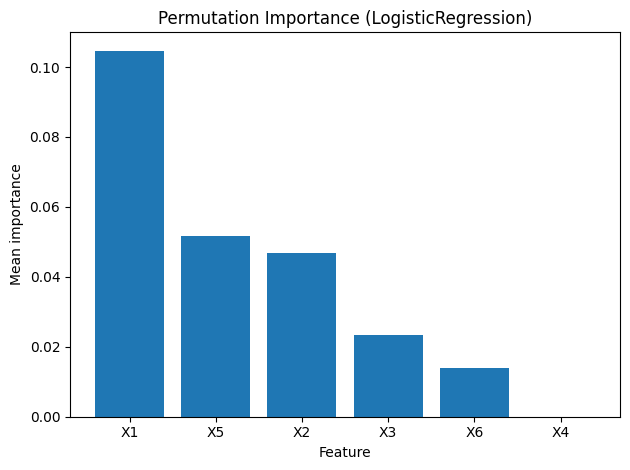

In [7]:
best_model_name = metrics_df.iloc[0]["model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print(f"\nPermutation importance on best model: {best_model_name}")
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42)
perm_df = pd.DataFrame({
    "feature": available_features,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False)
display(perm_df)

plt.figure()
plt.bar(perm_df["feature"], perm_df["perm_importance_mean"])
plt.title(f"Permutation Importance ({best_model_name})")
plt.xlabel("Feature"); plt.ylabel("Mean importance")
plt.tight_layout(); plt.show()

## Greedy Forward Feature Selection

This section implements a **greedy forward feature selection** algorithm to identify the most relevant subset of features that improves the model’s predictive accuracy.  
- The process begins with no features selected.  
- At each step, the algorithm evaluates all remaining features, adding the one that yields the highest accuracy improvement.  
- The loop continues until no further accuracy gains are achieved.  
- The results show the order in which features were added, the accuracy at each step, and the final best-performing feature set.

In [8]:
def evaluate_subset(features, model):
    X_tr = X_train[features]
    X_te = X_test[features]
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    return accuracy_score(y_test, y_pred)

selected = []
best_acc = 0.0
progress = []

for _ in range(len(available_features)):
    best_feat = None
    best_score_round = best_acc
    for feat in available_features:
        if feat in selected:
            continue
        trial = selected + [feat]
        score = evaluate_subset(trial, best_model)
        if score > best_score_round:
            best_score_round = score
            best_feat = feat
    if best_feat is not None:
        selected.append(best_feat)
        best_acc = best_score_round
        progress.append({"k_features": len(selected), "feature_added": best_feat, "accuracy": best_acc})
    else:
        break

subset_df = pd.DataFrame(progress)
if not subset_df.empty:
    display(subset_df)
    print("\nOrder by incremental gain:", " -> ".join(subset_df["feature_added"]))
    print(f"Best accuracy with {len(selected)} feature(s): {best_acc:.4f}")
else:
    print("No improvement found via greedy selection.")

k_features feature_added  accuracy
0           1            X6   0.71875


Order by incremental gain: X6
Best accuracy with 1 feature(s): 0.7188


## Model Training, Hyperparameter Tuning, and Evaluation

In this section, we compare multiple machine learning models (SVC, Logistic Regression, and HistGradientBoosting) across different feature subsets.  
We use cross-validation and grid search to tune hyperparameters, then evaluate each model on the test set using accuracy, precision, recall, F1-score, and ROC-AUC.  

The results are collected, ranked, and the best-performing model with its parameters is identified.

In [9]:
CSV_PATH = "ACME-HappinessSurvey2020.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)
X_all = df[[f"X{i}" for i in range(1, 7)]].copy()
y = df["Y"].copy()

# Fixed split (same as before)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_all, y, test_size=0.25, random_state=42, stratify=y
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Based on earlier importances: X1, X5, X2, X3 (X6 small, X4 near-zero for LR)
ranked = ["X1", "X5", "X2", "X3", "X6", "X4"]
subset_candidates = [
    ["X1","X5"],
    ["X1","X5","X2"],
    ["X1","X5","X2","X3"],
    ranked[:5],      # top-5
    ranked[:6],      # all
]

def score_model(model, grid, X_train, y_train):
    gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, refit=True)
    gs.fit(X_train, y_train)
    return gs.best_estimator_, gs.best_score_, gs.best_params_

def eval_test(est, X_test, y_test, name):
    y_pred = est.predict(X_test)
    try:
        y_proba = est.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test, y_proba)
    except Exception:
        roc = float("nan")
    return dict(
        model=name,
        accuracy=accuracy_score(y_test, y_pred),
        precision=precision_score(y_test, y_pred, zero_division=0),
        recall=recall_score(y_test, y_pred, zero_division=0),
        f1=f1_score(y_test, y_pred, zero_division=0),
        roc_auc=roc
    )

results = []
best_bundle = None  # (model_name, subset, best_estimator)

for subset in subset_candidates:
    X_train = X_train_full[subset]
    X_test  = X_test_full[subset]

    # 1) SVC (RBF) — slightly wider, still fast
    svc = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", probability=True, random_state=42))])
    svc_grid = {"svc__C": [0.5, 1, 2, 3, 5, 8, 12], "svc__gamma": ["scale", 0.05, 0.1, 0.2, 0.3]}
    svc_best, svc_cv_acc, svc_params = score_model(svc, svc_grid, X_train, y_train)
    svc_test = eval_test(svc_best, X_test, y_test, f"SVC_RBF | {subset}")
    svc_test["cv_mean_accuracy"] = svc_cv_acc
    svc_test["best_params"] = svc_params
    results.append(svc_test)

    # 2) Logistic Regression (try with/without class_weight)
    for cw in [None, "balanced"]:
        lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=5000, solver="lbfgs", class_weight=cw))])
        lr_grid = {"clf__C": [0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]}
        lr_best, lr_cv_acc, lr_params = score_model(lr, lr_grid, X_train, y_train)
        lr_test = eval_test(lr_best, X_test, y_test, f"LogReg(cw={cw}) | {subset}")
        lr_test["cv_mean_accuracy"] = lr_cv_acc
        lr_test["best_params"] = lr_params
        results.append(lr_test)

    # 3) HistGradientBoosting (small grid incl. mild L2)
    hgb = HistGradientBoostingClassifier(random_state=42)
    hgb_grid = {
        "learning_rate": [0.05, 0.1],
        "max_depth": [None, 5],
        "max_leaf_nodes": [31, 63],
        "min_samples_leaf": [10, 15],
        "l2_regularization": [0.0, 0.1, 0.5]
    }
    hgb_best, hgb_cv_acc, hgb_params = score_model(hgb, hgb_grid, X_train, y_train)
    hgb_test = eval_test(hgb_best, X_test, y_test, f"HGB | {subset}")
    hgb_test["cv_mean_accuracy"] = hgb_cv_acc
    hgb_test["best_params"] = hgb_params
    results.append(hgb_test)

res_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print("\nTop candidates by TEST accuracy:")
print(res_df.head(10))

best_row = res_df.iloc[0]
print("\nBest so far:")
print(best_row)



Top candidates by TEST accuracy:
                                               model  accuracy  precision    recall        f1   roc_auc  cv_mean_accuracy  \
0                                 HGB | ['X1', 'X5']   0.78125   0.761905  0.888889  0.820513  0.811508          0.596491   
1                             SVC_RBF | ['X1', 'X5']   0.75000   0.708333  0.944444  0.809524  0.851190          0.564327   
2                       SVC_RBF | ['X1', 'X5', 'X2']   0.75000   0.750000  0.833333  0.789474  0.791667          0.648538   
3                           HGB | ['X1', 'X5', 'X2']   0.75000   0.750000  0.833333  0.789474  0.763889          0.585965   
4                 SVC_RBF | ['X1', 'X5', 'X2', 'X3']   0.75000   0.750000  0.833333  0.789474  0.775794          0.552632   
5           SVC_RBF | ['X1', 'X5', 'X2', 'X3', 'X6']   0.71875   0.714286  0.833333  0.769231  0.821429          0.563158   
6  LogReg(cw=balanced) | ['X1', 'X5', 'X2', 'X3',...   0.71875   0.695652  0.888889  0.7804

In [2]:
cookiecutter https://github.com/drivendata/cookiecutter-data-science

SyntaxError: invalid syntax (3580079992.py, line 1)

In [3]:
from pathlib import Path
import shutil

PROJ = Path(r"C:/Users/hasan/OneDrive/Desktop/Apziva/1. Happy Customers Project/Happy_Customers")  # <-- change to your CCDS root
(PROJ / "data" / "raw").mkdir(parents=True, exist_ok=True)
(PROJ / "notebooks").mkdir(parents=True, exist_ok=True)
(PROJ / "references").mkdir(parents=True, exist_ok=True)

# COPY (edit the left-hand paths)
shutil.copy(r"C:/Users/hasan/OneDrive/Desktop/Apziva/1. Happy Customers Project/Happy_Customers/ACME-HappinessSurvey2020.csv", PROJ / "data" / "raw" / "ACME-HappinessSurvey2020.csv")
shutil.copy(r"C:\path\to\First Try.ipynb", PROJ / "notebooks" / "1.0-first-try.ipynb")
shutil.copy(r"C:\path\to\Second_Try.ipynb", PROJ / "notebooks" / "2.0-second-try.ipynb")
shutil.copy(r"C:\path\to\Happy_Customers_Project.ipynb", PROJ / "notebooks" / "3.0-final-solution.ipynb")
shutil.copy(r"C:\path\to\Project Description.docx", PROJ / "references" / "Project_Description.docx")

print("Files placed. You're good to go.")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\path\\to\\ACME-HappinessSurvey2020.csv'